<a href="https://colab.research.google.com/github/badbloody/diploma2023/blob/main/combinedMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the needed libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import os
import cv2
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from collections import defaultdict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Helper functions

In [ ]:
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
tensor_normalizer = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
epsilon = 1e-5


def preprocess_image(image, target_width=None):
    """Input PIL.Image object, output normalized four-dimensional tensor"""
    if target_width:
        t = transforms.Compose([
            transforms.Resize(target_width),
            transforms.CenterCrop(target_width),
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    else:
        t = transforms.Compose([
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    return t(image).unsqueeze(0)


def image_to_tensor(image, target_width=None):
    """Input OpenCV image, range 0~255, BGR order, output normalized four-dimensional tensor"""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return preprocess_image(image, target_width)


def read_image(path, target_width=None):
    """Input image path, output normalized four-dimensional tensor"""
    image = Image.open(path).convert("RGB")
    image = image.resize((256, 256))
    return preprocess_image(image, target_width)


def recover_image(tensor):
    """Input the four-dimensional tensor on the GPU, output the three-dimensional numpy matrix in the range of 0~255, RGB order"""
    image = tensor.detach().cpu().numpy()
    image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]


def recover_tensor(tensor):
    m = torch.tensor(cnn_normalization_mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(cnn_normalization_std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m
    return tensor.clamp(0, 1)


def imshow(tensor, title=None):
    """Feed a 4D tensor on the GPU and draw that image"""
    image = recover_image(tensor)
    print(image.shape)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


def mean_std(features):
    """Input the four features calculated by VGG16, output the mean and standard deviation of each feature map, the length is 1920"""
    mean_std_features = []
    for x in features:
        x = x.view(*x.shape[:2], -1)
        x = torch.cat([x.mean(-1), torch.sqrt(x.var(-1) + epsilon)], dim=-1)
        n = x.shape[0]
        x2 = x.view(n, 2, -1).transpose(2, 1).contiguous().view(n, -1) # 【mean, ..., std, ...] to [mean, std, ...]
        mean_std_features.append(x2)
    mean_std_features = torch.cat(mean_std_features, dim=-1)
    return mean_std_features


class Smooth:
    # Perform a moving average on the input data
    def __init__(self, windowsize=100):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 1), dtype=np.float32)
        self.index = 0

    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

    def __float__(self):
        return float(self.data.mean())

    def __format__(self, f):
        return self.__float__().__format__(f)

In [ ]:
class VGG(nn.Module):

    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs


class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(MyConv2D, self).__init__()
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = torch.zeros(out_channels).to(device)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        return s.format(**self.__dict__)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1),
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x


def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1,
    upsample=None, instance_norm=True, relu=True, trainable=False):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    if trainable:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    else:
        layers.append(MyConv2D(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers


class TransformNet(nn.Module):
    def __init__(self, base=8):
        super(TransformNet, self).__init__()
        self.base = base
        self.weights = []
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9, trainable=True),
            *ConvLayer(base, base*2, kernel_size=3, stride=2),
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2),
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False, trainable=True),
        )
        self.get_param_dict()

    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

    def get_param_dict(self):
        """Find all MyConv2D layers of the network and calculate the number of weights they need"""
        param_dict = defaultdict(int)
        def dfs(module, name):
            for name2, layer in module.named_children():
                dfs(layer, '%s.%s' % (name, name2) if name != '' else name2)
            if module.__class__ == MyConv2D:
                param_dict[name] += int(np.prod(module.weight.shape))
                param_dict[name] += int(np.prod(module.bias.shape))
        dfs(self, '')
        return param_dict

    def set_my_attr(self, name, value):
        # The following loop traverses a string similar to residuals.0.conv.1 step by step to find the corresponding weight
        target = self
        for x in name.split('.'):
            if x.isnumeric():
                target = target.__getitem__(int(x))
            else:
                target = getattr(target, x)

        # Set the corresponding weight
        n_weight = np.prod(target.weight.shape)
        target.weight = value[:n_weight].view(target.weight.shape)
        target.bias = value[n_weight:].view(target.bias.shape)

    def set_weights(self, weights, i=0):
        """Input weight dictionary, set weights for all MyConv2D layers of this network"""
        for name, param in weights.items():
            self.set_my_attr(name, weights[name][i])


class MetaNet(nn.Module):
    def __init__(self, param_dict):
        super(MetaNet, self).__init__()
        self.param_num = len(param_dict)
        self.hidden = nn.Linear(1920, 128*self.param_num)
        self.fc_dict = {}
        for i, (name, params) in enumerate(param_dict.items()):
            self.fc_dict[name] = i
            setattr(self, 'fc{}'.format(i+1), nn.Linear(128, params))

    def forward(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters

Connecting to Google Drive and importing the style images from the GitHub repository to process them:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/badbloody/diplomskiSlike

Cloning into 'diplomskiSlike'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 48 (delta 1), reused 2 (delta 0), pack-reused 42
Unpacking objects: 100% (48/48), 89.31 MiB | 11.28 MiB/s, done.


Using only portrait style images at the moment:

In [ ]:
%rm -rf styleImages #delete if there is a folder from the previuous session

current_dir = 'diplomskiSlike/abstractLiquify' #define which style images you want here (either portraits, abstractLiquify or sketches)
style_dir = '/content/styleImages'

processed_style_dir = os.path.join(style_dir, "train")
os.makedirs(processed_style_dir, exist_ok=True)

for filename in os.listdir(current_dir):
  shutil.copy2(os.path.join(current_dir, filename), processed_style_dir)

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

style_dataset = ImageFolder(root=style_dir, transform=data_transform)

Importing the COCO Train dataset for content images and processing them:

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/00

In [ ]:
# Define the paths
dataset_dir = "/content/train2017"
reduced_dataset_dir = "/content/reduced_coco"

# Create the reduced dataset directory
os.makedirs(reduced_dataset_dir, exist_ok=True)

# Set the desired number of images
desired_num_images = 15000

# Get a list of image filenames from the original dataset
image_filenames = os.listdir(dataset_dir)

# Shuffle the list of image filenames
random.shuffle(image_filenames)

# Select the desired number of images
selected_images = image_filenames[:desired_num_images]

# Copy the selected images to the reduced dataset directory
for image_filename in selected_images:
    shutil.copy2(os.path.join(dataset_dir, image_filename), reduced_dataset_dir)

In [ ]:
reduced_processed_dir = "/content/reduced_coco_processed"

# Create the processed dataset directory
reduced_processed_dataset_dir = os.path.join(reduced_processed_dir, "train")
os.makedirs(reduced_processed_dataset_dir, exist_ok=True)

# Copy images to the processed directory
for filename in os.listdir(reduced_dataset_dir):
    shutil.copy2(os.path.join(reduced_dataset_dir, filename), reduced_processed_dataset_dir)

# Define the data transformations
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
])

# Load the processed dataset using ImageFolder
content_dataset = ImageFolder(root=reduced_processed_dir, transform=data_transform)

In [ ]:
batch_size = 4
width = 255
data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, shuffle=True)

Importing the vgg16 model:

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 230MB/s]


In [ ]:
def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1,
    upsample=None, instance_norm=True, relu=True):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1),
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x

class TransformNet(nn.Module):
    def __init__(self, base=32):
        super(TransformNet, self).__init__()
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9),
            *ConvLayer(base, base*2, kernel_size=3, stride=2),
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2),
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False),
        )

    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

In [ ]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

Helper function to save results in an image file:

In [ ]:
%mkdir -p debug

def tensor_to_array(tensor):
    x = tensor.cpu().detach().numpy()
    x = (x*255).clip(0, 255).transpose(0, 2, 3, 1).astype(np.uint8)
    return x

def save_debug_image(style_images, content_images, transformed_images, filename):
    style_image = Image.fromarray(recover_image(style_images))
    content_images = [recover_image(x) for x in content_images]
    transformed_images = [recover_image(x) for x in transformed_images]

    new_im = Image.new('RGB', (style_image.size[0] + (width + 5) * 4, max(style_image.size[1], width*2 + 5)))
    new_im.paste(style_image, (0,0))

    x = style_image.size[0] + 5
    for i, (a, b) in enumerate(zip(content_images, transformed_images)):
        new_im.paste(Image.fromarray(a), (x + (width + 5) * i, 0))
        new_im.paste(Image.fromarray(b), (x + (width + 5) * i, width + 5))

    new_im.save(filename)

In [ ]:
transform_net = TransformNet(32).to(device)

Training stage:

In [ ]:
verbose_batch = 100
#style_weight = 1e5
style_weight = 1e4
content_weight = 1
tv_weight = 1e-6

optimizer = optim.Adam(transform_net.parameters(), 1e-3)
transform_net.train()

desired_iterations = 601
switch_style = 80

#n_batch = len(data_loader)
n_batch = min(len(data_loader), desired_iterations)

iteration = 0

for epoch in range(1):
    print('Epoch: {}'.format(epoch+1))
    smooth_content_loss = Smooth()
    smooth_style_loss = Smooth()
    smooth_tv_loss = Smooth()
    smooth_loss = Smooth()
    with tqdm(enumerate(data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            optimizer.zero_grad()

            # Randomly select a new style image every 20 batches, and calculate its features
            if batch % switch_style == 0:
                style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
                style_features = vgg16(style_image)
                style_mean_std = mean_std(style_features)
                style_grams = [gram_matrix(x) for x in style_features]
                style_grams = [x.detach() for x in style_grams]

            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)
            transformed_images = transformed_images.clamp(-3, 3)

            # Compute features using vgg16
            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)

            # content loss
            content_loss = content_weight * F.mse_loss(transformed_features[1], content_features[1])

            # total variation loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            # style loss
            style_loss = 0.
            transformed_grams = [gram_matrix(x) for x in transformed_features]
            for transformed_gram, style_gram in zip(transformed_grams, style_grams):
                style_loss += style_weight * F.mse_loss(transformed_gram,
                                                        style_gram.expand_as(transformed_gram))

            # 加起来
            loss = style_loss + content_loss + tv_loss

            loss.backward()
            optimizer.step()

            smooth_content_loss += content_loss.item()
            smooth_style_loss += style_loss.item()
            smooth_tv_loss += tv_loss.item()
            smooth_loss += loss.item()

            s = f'Content: {smooth_content_loss:.2f} '
            s += f'Style: {smooth_style_loss:.2f} '
            s += f'TV: {smooth_tv_loss:.4f} '
            s += f'Loss: {smooth_loss:.2f}'
            if batch % verbose_batch == 0:
                s = '\n' + s
                save_debug_image(style_image, content_images, transformed_images,
                                 f"debug/s2_{epoch}_{batch}.jpg")

            pbar.set_description(s)

            if batch + 1 >= desired_iterations:
              break
    torch.save(transform_net.state_dict(), 'transform_net.pth')

Epoch: 1


  0%|          | 0/601 [00:00<?, ?it/s]
Content: 8.42 Style: 16.81 TV: 0.2547 Loss: 25.48:   0%|          | 0/601 [00:21<?, ?it/s]
Content: 7.74 Style: 15.27 TV: 0.0587 Loss: 23.07:  17%|█▋        | 100/601 [30:20<2:35:18, 18.60s/it]
Content: 7.76 Style: 15.23 TV: 0.0567 Loss: 23.05:  17%|█▋        | 100/601 [30:38<2:35:18, 18.60s/it]
Content: 8.20 Style: 11.05 TV: 0.0853 Loss: 19.34:  33%|███▎      | 200/601 [1:01:13<2:02:10, 18.28s/it]
Content: 8.16 Style: 10.98 TV: 0.0855 Loss: 19.23:  33%|███▎      | 200/601 [1:01:31<2:02:10, 18.28s/it]
Content: 6.25 Style: 4.57 TV: 0.0932 Loss: 10.91:  50%|████▉     | 300/601 [1:31:57<1:33:18, 18.60s/it]
Content: 6.25 Style: 4.53 TV: 0.0934 Loss: 10.87:  50%|████▉     | 300/601 [1:32:15<1:33:18, 18.60s/it]
Content: 7.32 Style: 6.30 TV: 0.1747 Loss: 13.79:  67%|██████▋   | 400/601 [2:02:24<1:00:25, 18.04s/it]
Content: 7.35 Style: 6.35 TV: 0.1759 Loss: 13.87:  67%|██████▋   | 400/601 [2:02:43<1:00:25, 18.04s/it]
Content: 7.24 Style: 4.63 TV: 0.1771 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


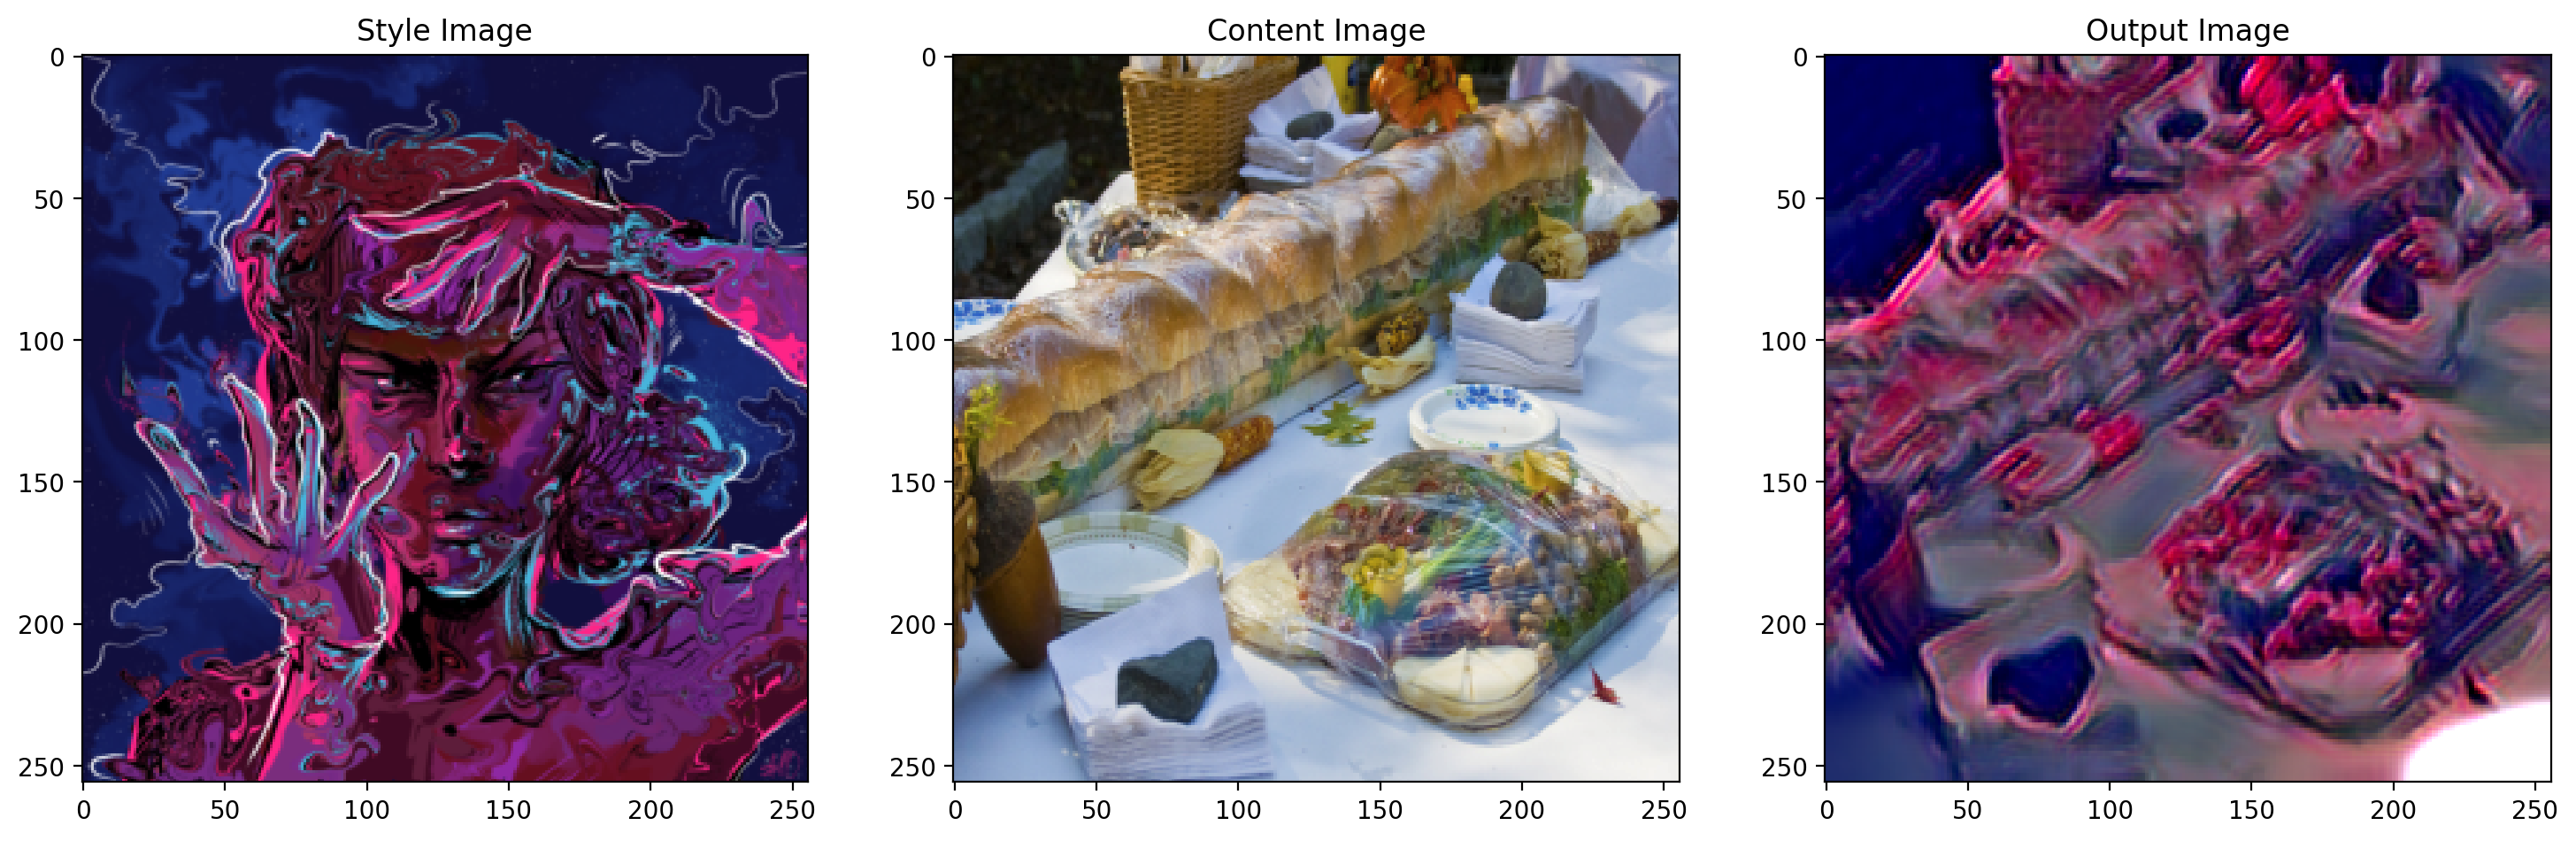

In [ ]:
content_img = random.choice(content_dataset)[0].unsqueeze(0).to(device)
output_img = transform_net(content_img)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
imshow(style_image, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
imshow(output_img.detach(), title='Output Image')